In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial.distance import cosine, euclidean, mahalanobis
from scipy.stats import wasserstein_distance
from sklearn.covariance import EmpiricalCovariance
from tqdm import tqdm
import joblib

In [2]:
import sklearn
print(sklearn.__version__)


1.5.2


In [3]:
#data loading
import os
import pandas as pd

# directory where tabddpm_1 to tabddpm_30 folders are located
root_pth = "/Users/tejaswiduptala/Desktop/AISP/tabddpm_black_box_adapted_pra"

def load_dataset_components(dataset_index):
    """
    Loads all components (challenge, synthetic, label, and train) for one dataset.
    the dataset index(1–30)

    returns 
    'challenge', 'synthetic', 'label', and (if 1–20) 'train'.


    """
    folder_name = f"tabddpm_{dataset_index}"
    dataset_path = os.path.join(root_pth, folder_name)

    files = {
        "challenge": "challenge_with_id.csv",
        "synthetic": "trans_synthetic.csv",
        "label": "challenge_label.csv",
        "train": "train_with_id.csv" if dataset_index <= 20 else None
    }

    loaded = {}

    for key, filename in files.items():
        if filename is None:
            loaded[key] = None
            continue

        file_path = os.path.join(dataset_path, filename)
        if os.path.exists(file_path):
            loaded[key] = pd.read_csv(file_path)
        else:
            print(f"Missing file: {file_path}")
            loaded[key] = None

    return loaded

def load_all_datasets(start=1, end=30):
    """
    Loads all datasets from tabddpm_1 to tabddpm_30 into a dictionary.

    returns
    dictionary mapping dataset indices to their loaded components(load_dataset_components)

    """
    all_data = {}
    for idx in range(start, end + 1):
        print(f"Loading dataset {idx}")
        all_data[idx] = load_dataset_components(idx)
    return all_data

# Example usage
all_datasets = load_all_datasets()

# Access example
print("\nDataset 1")
print("Challenge:", all_datasets[1]['challenge'].shape)
print("Synthetic:", all_datasets[1]['synthetic'].shape)
print("Label:", all_datasets[1]['label'].shape)
if all_datasets[1]['train'] is not None:
    print("Train:", all_datasets[1]['train'].shape)


Loading dataset 1
Loading dataset 2
Loading dataset 3
Loading dataset 4
Loading dataset 5
Loading dataset 6
Loading dataset 7
Loading dataset 8
Loading dataset 9
Loading dataset 10
Loading dataset 11
Loading dataset 12
Loading dataset 13
Loading dataset 14
Loading dataset 15
Loading dataset 16
Loading dataset 17
Loading dataset 18
Loading dataset 19
Loading dataset 20
Loading dataset 21
Loading dataset 22
Loading dataset 23
Loading dataset 24
Loading dataset 25
Loading dataset 26
Loading dataset 27
Loading dataset 28
Loading dataset 29
Loading dataset 30

Dataset 1
Challenge: (200, 10)
Synthetic: (20000, 8)
Label: (200, 1)
Train: (20000, 10)


In [4]:
#preproccessing

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
#  column groups
NUMERIC_COLUMNS = ['trans_date', 'amount', 'balance']
CATEGORICAL_COLUMNS = ['trans_type', 'operation', 'k_symbol', 'bank']
ID_COLUMNS = ['trans_id', 'account_id', 'account']

def build_columnwise_preprocessor():
    """
    Builds a preprocessor that handles each column individually.
    each numerical column: impute mean, scale.
    each categorical column: impute mode, one hot encode.
    returns
    the preprocessor and the final feature names.
    """

    transformers = []

    # numerical columns: one pipeline per column
    for col in NUMERIC_COLUMNS:
        transformers.append(
            (f'num_{col}', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), [col])
        )

    # categorical columns: one pipeline per column
    for col in CATEGORICAL_COLUMNS:
        transformers.append(
            (f'cat_{col}', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), [col])
        )

    return ColumnTransformer(transformers, remainder='drop')

def apply_preprocessing_per_column(data_dict, preprocessor=None, fit=True):
    """
    Applies the preprocessor to challenge, synthetic, and train datasets.
    
    returns
    dictionary mapping 'challenge', 'synthetic', 'train' to processed arrays.

    """
    # combine all available parts for unified processing
    all_parts = []
    for name in ['challenge', 'synthetic', 'train']:
        if data_dict.get(name) is not None:
            part = data_dict[name].copy()
            part['__source__'] = name
            all_parts.append(part)

    combined = pd.concat(all_parts, ignore_index=True)
    combined = combined.drop(columns=ID_COLUMNS, errors='ignore')

    if fit:
        preprocessor = build_columnwise_preprocessor()
        transformed = preprocessor.fit_transform(combined)
    else:
        transformed = preprocessor.transform(combined)

    # split back by source
    result = {}
    start = 0
    for name in ['challenge', 'synthetic', 'train']:
        if data_dict.get(name) is not None:
            length = len(data_dict[name])
            result[name] = transformed[start:start + length]
            start += length

    return result, preprocessor

def preprocess_all_datasets(all_datasets):
    """
    Applies columnwise preprocessing to all datasets (1–30).
    returns 
    a dictionary with the same structure as all_datasets,
    but with preprocessed 'challenge', 'synthetic', and 'train' arrays.
    """
    all_processed = {}
    global_preprocessor = None

    # Step 1: Fit the preprocessor on all available train data (datasets 1–20)
    combined_train_data = []
    for idx in range(1, 21):
        train_data = all_datasets[idx]['train']
        if train_data is not None:
            train_data = train_data.copy()
            train_data['__source__'] = f'train_{idx}'
            combined_train_data.append(train_data)

    all_train_df = pd.concat(combined_train_data, ignore_index=True)
    all_train_df = all_train_df.drop(columns=ID_COLUMNS, errors='ignore')

    # Fit preprocessor
    global_preprocessor = build_columnwise_preprocessor()
    global_preprocessor.fit(all_train_df)

    # Step 2: Apply to each dataset
    for idx in range(1, 31):
        dataset = all_datasets[idx]
        to_preprocess = {}

        for split in ['challenge', 'synthetic', 'train']:
            if dataset[split] is not None:
                to_preprocess[split] = dataset[split]

        processed, _ = apply_preprocessing_per_column(to_preprocess, preprocessor=global_preprocessor, fit=False)
        all_processed[idx] = processed

    return all_processed, global_preprocessor

# Example usage
all_processed_datasets, preprocessor = preprocess_all_datasets(all_datasets)

# Access example processed data for dataset 1
print("Processed Dataset 1 Shapes:")
print("Challenge:", all_processed_datasets[1]['challenge'].shape)
print("Synthetic:", all_processed_datasets[1]['synthetic'].shape)
if 'train' in all_processed_datasets[1]:
    print("Train:", all_processed_datasets[1]['train'].shape)


Processed Dataset 1 Shapes:
Challenge: (200, 35)
Synthetic: (20000, 35)
Train: (20000, 35)


In [5]:
#17 features
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.covariance import EmpiricalCovariance
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial import distance
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel
from sklearn.metrics.pairwise import euclidean_distances

'''def compute_mahalanobis_distance(challenge, synthetic):
    """Computes Mahalanobis distance of each challenge row from the synthetic distribution."""
    cov = EmpiricalCovariance().fit(synthetic)
    return cov.mahalanobis(challenge)'''


def compute_mahalanobis_distance(challenge, synthetic):
    """
    compute full Mahalanobis distance matrix: challenge x synthetic
    returns
    Matrix of Mahalanobis distances (challenge rows x synthetic rows).

    """
    cov = EmpiricalCovariance().fit(synthetic)
    mahalanobis_matrix = np.zeros((challenge.shape[0], synthetic.shape[0]))
    for i, x in enumerate(challenge):
        diffs = synthetic - x
        mahalanobis_matrix[i] = np.sqrt(np.sum(diffs @ cov.precision_ * diffs, axis=1))
    return mahalanobis_matrix




def compute_mmd_kernel_values(y, kernel='rbf', gamma=1.0):
    """Precomputes Kyy mean for MMD computation."""
    if kernel == 'rbf':
        Kyy_mean = np.mean(rbf_kernel(y, y, gamma=gamma))
    elif kernel == 'linear':
        Kyy_mean = np.mean(linear_kernel(y, y))
    else:
        raise ValueError("Unsupported kernel")
    return Kyy_mean

def compute_mmd_per_row(x_row, y, Kyy_mean, kernel='rbf', gamma=1.0):
    """Computes MMD between one challenge row and all synthetic rows, using precomputed Kyy_mean."""
    x_row = x_row.reshape(1, -1)

    if kernel == 'rbf':
        Kxx = rbf_kernel(x_row, x_row, gamma=gamma)[0][0]
        Kxy = np.mean(rbf_kernel(x_row, y, gamma=gamma))
    elif kernel == 'linear':
        Kxx = linear_kernel(x_row, x_row)[0][0]
        Kxy = np.mean(linear_kernel(x_row, y))
    else:
        raise ValueError("Unsupported kernel")

    return Kxx + Kyy_mean - 2 * Kxy





def extract_distance_features(challenge, synthetic):
    """
    compute distance-based features and summary statistics for each challenge row.

    computes cosine, Euclidean, Mahalanobis distances to synthetic rows,
    compute per-row MMD (RBF and linear)
    returns
    DataFrame of distance-based features 17 features
    """
    distances = {
        'cosine': cdist(challenge, synthetic, metric='cosine'),
        'euclidean': cdist(challenge, synthetic, metric='euclidean'),
        'mahalanobis': compute_mahalanobis_distance(challenge, synthetic)
    }

    # Precompute once for the entire dataset
    mmd_rbf_yy = compute_mmd_kernel_values(synthetic, kernel='rbf', gamma=1.0)
    mmd_linear_yy = compute_mmd_kernel_values(synthetic, kernel='linear')

    features = []
    for i in range(len(challenge)):
        row_features = {}

        for dist_type, dist_matrix in distances.items():
            if dist_type == 'mahalanobis':
                
                row_dists = dist_matrix[i]
                row_features[f'{dist_type}_min'] = np.min(row_dists)
                row_features[f'{dist_type}_mean'] = np.mean(row_dists)
                row_features[f'{dist_type}_std'] = np.std(row_dists)
                row_features[f'{dist_type}_median'] = np.median(row_dists)
                row_features[f'{dist_type}_top5_mean'] = np.mean(np.partition(row_dists, 5)[:5])

            else:
                row_dists = dist_matrix[i]
                row_features[f'{dist_type}_min'] = np.min(row_dists)
                row_features[f'{dist_type}_mean'] = np.mean(row_dists)
                row_features[f'{dist_type}_std'] = np.std(row_dists)
                row_features[f'{dist_type}_median'] = np.median(row_dists)
                row_features[f'{dist_type}_top5_mean'] = np.mean(np.partition(row_dists, 5)[:5])

        # Fast MMD using precomputed Kyy
        row_features['mmd_rbf'] = compute_mmd_per_row(challenge[i], synthetic, Kyy_mean=mmd_rbf_yy, kernel='rbf', gamma=1.0)
        row_features['mmd_linear'] = compute_mmd_per_row(challenge[i], synthetic, Kyy_mean=mmd_linear_yy, kernel='linear')

        features.append(row_features)

    return pd.DataFrame(features)



# PROCESS ALL DATASETS 1–30 
all_distance_features = {}

for idx in range(1, 31):
    print(f"Processing distances for dataset {idx}")
    challenge = all_processed_datasets[idx]['challenge']
    synthetic = all_processed_datasets[idx]['synthetic']
    
    try:
        distance_df = extract_distance_features(challenge, synthetic)
        all_distance_features[idx] = distance_df
    except Exception as e:
        print(f"Error processing dataset {idx}: {e}")


Processing distances for dataset 1
Processing distances for dataset 2
Processing distances for dataset 3
Processing distances for dataset 4
Processing distances for dataset 5
Processing distances for dataset 6
Processing distances for dataset 7
Processing distances for dataset 8
Processing distances for dataset 9
Processing distances for dataset 10
Processing distances for dataset 11
Processing distances for dataset 12
Processing distances for dataset 13
Processing distances for dataset 14
Processing distances for dataset 15
Processing distances for dataset 16
Processing distances for dataset 17
Processing distances for dataset 18
Processing distances for dataset 19
Processing distances for dataset 20
Processing distances for dataset 21
Processing distances for dataset 22
Processing distances for dataset 23
Processing distances for dataset 24
Processing distances for dataset 25
Processing distances for dataset 26
Processing distances for dataset 27
Processing distances for dataset 28
P

In [6]:
# Show the first few rows of the computed distance features for dataset 1
print(all_distance_features[1].head())
df = all_distance_features[1]
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.describe())



     cosine_min  cosine_mean  cosine_std  cosine_median  cosine_top5_mean  \
0  6.407198e-03     0.824757    0.266651       0.808298          0.014339   
1  4.153310e-07     0.817621    0.333001       0.852381          0.000270   
2  4.344303e-04     0.641392    0.308271       0.650005          0.000656   
3  2.519918e-02     0.849573    0.229373       0.874899          0.035164   
4  3.675371e-04     0.577387    0.295814       0.628461          0.000659   

   euclidean_min  euclidean_mean  euclidean_std  euclidean_median  \
0       0.280302        3.164875       0.890263          2.999590   
1       0.003542        3.604303       0.981509          3.649817   
2       0.090200        2.785416       0.979189          2.806312   
3       0.534841        3.206031       0.638887          3.215356   
4       0.059953        2.506833       1.018576          2.565027   

   euclidean_top5_mean  mahalanobis_min  mahalanobis_mean  mahalanobis_std  \
0             0.398968         0.340638     

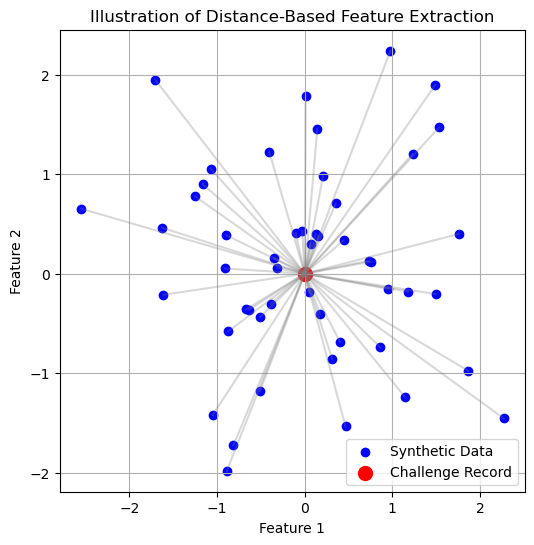

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Random points for synthetic data
np.random.seed(0)
synthetic_points = np.random.randn(50, 2)  # 50 synthetic samples in 2D

# One challenge point
challenge_point = np.array([0, 0])

plt.figure(figsize=(6,6))
plt.scatter(synthetic_points[:,0], synthetic_points[:,1], c='blue', label='Synthetic Data')
plt.scatter(challenge_point[0], challenge_point[1], c='red', label='Challenge Record', s=100)

# Draw lines (distances) from challenge to synthetic points
for pt in synthetic_points:
    plt.plot([challenge_point[0], pt[0]], [challenge_point[1], pt[1]], 'gray', alpha=0.3)

plt.legend()
plt.title('Illustration of Distance-Based Feature Extraction')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()


In [8]:
#Merging
 # MERGE DISTANCE FEATURES WITH LABELS FOR DATASETS 1–20 
merged_features_labels = {}

for idx in range(1, 21):  # Only datasets 1 to 20 have labels
    print(f"Merging features and labels for dataset {idx}")
    
    features_df = all_distance_features[idx]
    labels_df = all_datasets[idx]['label']

    # Ensure both DataFrames align
    if len(features_df) != len(labels_df):
        print(f"Length mismatch in dataset {idx}: features ({len(features_df)}), labels ({len(labels_df)})")
        continue

    merged = features_df.copy()
    merged['label'] = labels_df['is_train'].values
    merged_features_labels[idx] = merged

print(merged_features_labels[1].head(10))


Merging features and labels for dataset 1
Merging features and labels for dataset 2
Merging features and labels for dataset 3
Merging features and labels for dataset 4
Merging features and labels for dataset 5
Merging features and labels for dataset 6
Merging features and labels for dataset 7
Merging features and labels for dataset 8
Merging features and labels for dataset 9
Merging features and labels for dataset 10
Merging features and labels for dataset 11
Merging features and labels for dataset 12
Merging features and labels for dataset 13
Merging features and labels for dataset 14
Merging features and labels for dataset 15
Merging features and labels for dataset 16
Merging features and labels for dataset 17
Merging features and labels for dataset 18
Merging features and labels for dataset 19
Merging features and labels for dataset 20
     cosine_min  cosine_mean  cosine_std  cosine_median  cosine_top5_mean  \
0  6.407198e-03     0.824757    0.266651       0.808298          0.01433

In [9]:
import numpy as np
all_labels = np.hstack([all_datasets[i]['label']['is_train'].values for i in range(1, 21)])
print("Label distribution:", np.bincount(all_labels))



Label distribution: [2000 2000]


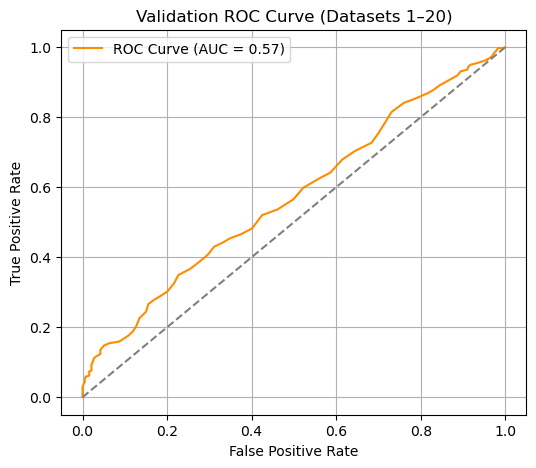

Model trained. Validation AUC: 0.5718


In [10]:

#random forest classifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import os
import joblib

train_frames = []
for idx in merged_features_labels:
    df = merged_features_labels[idx]
    df['dataset'] = idx  
    train_frames.append(df)

full_train_df = pd.concat(train_frames, ignore_index=True)

# Step 3: Separate features and labels
X_train = full_train_df.drop(columns=['label', 'dataset'])
y_train = full_train_df['label']


# Step 4: Split into training and validation sets 
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Step 5: Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_tr, y_tr)

#Step 6: Predict and Evaluate 
y_scores = clf.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)

# Step 7: Plot ROC Curve 
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve (Datasets 1–20)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Model trained. Validation AUC: {roc_auc:.4f}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validated AUC: 0.5745450000000001


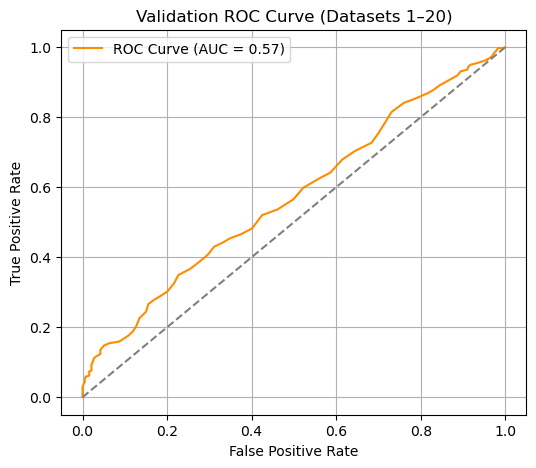

In [11]:

#random forest improved one
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

# STEP 1: Prepare Unified Training Data 
X = []
y = []

for idx in range(1, 21):
    df = merged_features_labels[idx]
    X.append(df.drop(columns=['label']).values)
    y.append(df['label'].values)

X = np.vstack(X)
y = np.hstack(y)

#STEP 2: Define Parameter Grid for Tuning 
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# STEP 3: Run GridSearch with Stratified 5-Fold CV 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

#STEP 4: Output Best Parameters and Score 
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validated AUC:", grid_search.best_score_)


#Step 7: Plot ROC Curve 
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve (Datasets 1–20)')
plt.legend()
plt.grid(True)
plt.show()


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best Cross-Validated ROC-AUC: 0.5931


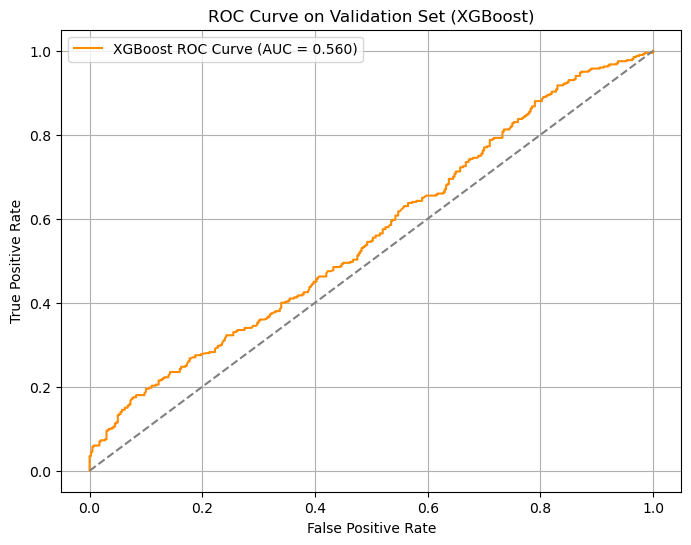

In [12]:
#xgb

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Concatenate into a single DataFrame
df_list = [merged_features_labels[i] for i in range(1, 21)]
df_full = pd.concat(df_list, ignore_index=True)

X = df_full.drop(columns=['label'])
y = df_full['label']

# Train-test split for evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define XGBoost classifier
#xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# Hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Set up GridSearch with 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=cv,
                           verbose=1,
                           n_jobs=-1)

# Run Grid Search to find the best parameters
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validated ROC-AUC: {grid_search.best_score_:.4f}")

# Evaluate on the validation set
best_model = grid_search.best_estimator_
y_proba = best_model.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(y_val, y_proba)
fpr, tpr, _ = roc_curve(y_val, y_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost ROC Curve (AUC = {roc_auc:.3f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Validation Set (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [05:29:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


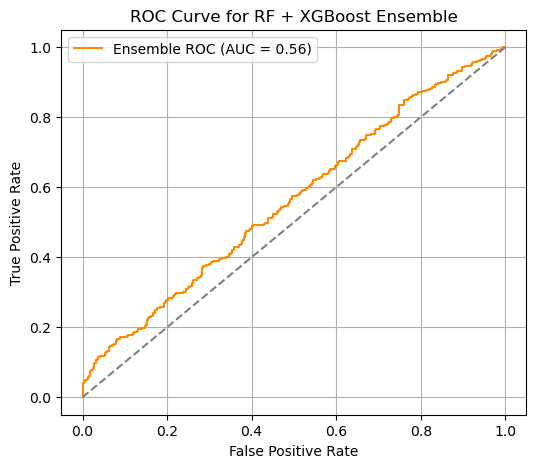

In [13]:
#combined 

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



# Combine all datasets into training data
train_frames = []
for idx in merged_features_labels:
    df = merged_features_labels[idx]
    df['dataset'] = idx
    train_frames.append(df)
full_train_df = pd.concat(train_frames, ignore_index=True)

# Features and labels
X = full_train_df.drop(columns=['label', 'dataset'])
y = full_train_df['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define classifiers
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_clf = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Combine using soft voting
voting_clf = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb_clf)], voting='soft')
voting_clf.fit(X_train, y_train)

# Evaluate on validation set
y_probs = voting_clf.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_probs)
fpr, tpr, _ = roc_curve(y_val, y_probs)

# Plot ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Ensemble ROC (AUC = {auc_score:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RF + XGBoost Ensemble')
plt.legend()
plt.grid(True)
plt.show()



[LightGBM] [Info] Number of positive: 1579, number of negative: 1621
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493437 -> initscore=-0.026252
[LightGBM] [Info] Start training from score -0.026252


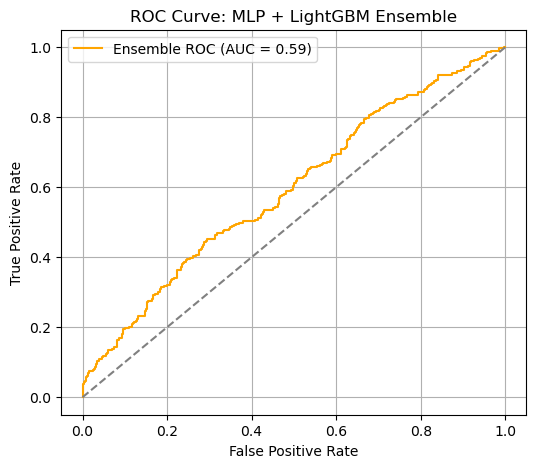

In [14]:


#combine MLP and  LightGBM
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Combine datasets
train_frames = []
for idx in merged_features_labels:
    df = merged_features_labels[idx]
    df['dataset'] = idx
    train_frames.append(df)
full_train_df = pd.concat(train_frames, ignore_index=True)

# Features and labels
X = full_train_df.drop(columns=['label', 'dataset'])
y = full_train_df['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for MLP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train LightGBM
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)

# Train MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu',
                          solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

# Predict probabilities
lgb_prob = lgb_model.predict_proba(X_val)[:, 1]
mlp_prob = mlp_model.predict_proba(X_val_scaled)[:, 1]

# Soft voting (average)
ensemble_prob = 0.5 * lgb_prob + 0.5 * mlp_prob

# AUC
auc_score = roc_auc_score(y_val, ensemble_prob)
fpr, tpr, _ = roc_curve(y_val, ensemble_prob)

# Plot ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Ensemble ROC (AUC = {auc_score:.2f})', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: MLP + LightGBM Ensemble')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
pip install lightgbm


Note: you may need to restart the kernel to use updated packages.


In [16]:
# Recreate validation set and ensemble prediction from earlier steps for TPR@10%FPR

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# Prepare simulated training data again
train_frames = []
for idx in merged_features_labels:
    df = merged_features_labels[idx]
    df['dataset'] = idx
    train_frames.append(df)
full_train_df = pd.concat(train_frames, ignore_index=True)

# Train/Validation split
X = full_train_df.drop(columns=['label', 'dataset'])
y = full_train_df['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# MLP needs scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu',
                          solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

# Train XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100,eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict probabilities
mlp_probs1 = mlp_model.predict_proba(X_val_scaled)[:, 1]
xgb_probs1 = xgb_model.predict_proba(X_val)[:, 1]
ensemble_probs1 = 0.5 * mlp_probs1 + 0.5 * xgb_probs1

# Compute TPR@10%FPR
def compute_tpr_at_fpr_threshold(y_true, y_probs1, fpr_threshold=0.10):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs1)
    valid = fpr <= fpr_threshold
    return np.max(tpr[valid]) if np.any(valid) else 0.0

tpr_10_fpr = compute_tpr_at_fpr_threshold(y_val, ensemble_probs1, fpr_threshold=0.10)
tpr_10_fpr



0.171021377672209

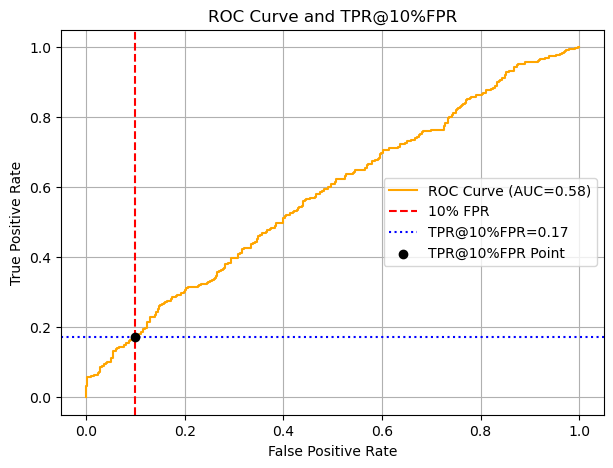

TPR@10%FPR: 0.171


In [17]:
#plot and roc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assume y_val = true labels, ensemble_probs1 = predicted probabilities

# Compute ROC
fpr, tpr, thresholds = roc_curve(y_val, ensemble_probs1)
auc_score = roc_auc_score(y_val, ensemble_probs1)

# Find TPR@10%FPR
fpr_threshold = 0.10
tpr_at_10fpr = np.max(tpr[fpr <= fpr_threshold])

# Plot ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='orange', label=f'ROC Curve (AUC={auc_score:.2f})')
plt.axvline(fpr_threshold, color='red', linestyle='--', label='10% FPR')
plt.axhline(tpr_at_10fpr, color='blue', linestyle=':', label=f'TPR@10%FPR={tpr_at_10fpr:.2f}')
plt.scatter([fpr_threshold], [tpr_at_10fpr], color='black', zorder=5, label='TPR@10%FPR Point')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve and TPR@10%FPR')
plt.legend()
plt.grid(True)
plt.show()

print(f"TPR@10%FPR: {tpr_at_10fpr:.3f}")


[LightGBM] [Info] Number of positive: 1579, number of negative: 1621
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493437 -> initscore=-0.026252
[LightGBM] [Info] Start training from score -0.026252
Ensemble AUC: 0.558
TPR@10%FPR: 0.178


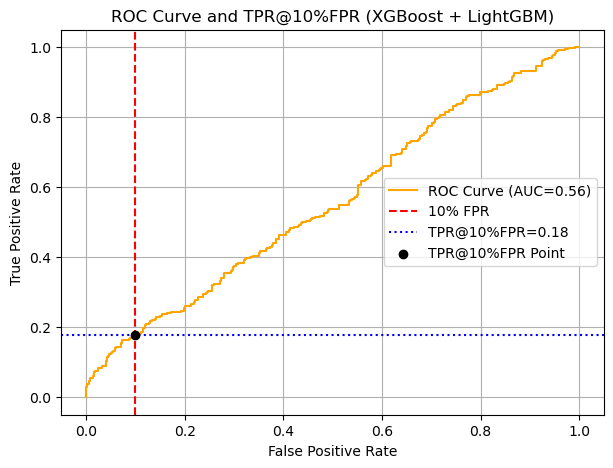

In [18]:

#lgb+xgb
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

#Train XGBoost ---
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

#Train LightGBM 
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)

#Predict probabilities for validation set
xgb_probs2 = xgb_model.predict_proba(X_val)[:, 1]
lgb_probs2 = lgb_model.predict_proba(X_val)[:, 1]

#Soft voting ensemble
ensemble_probs2 = 0.5 * xgb_probs2 + 0.5 * lgb_probs2

#AUC 
auc_score = roc_auc_score(y_val, ensemble_probs2)
print(f"Ensemble AUC: {auc_score:.3f}")

#ROC + TPR@10%FPR 
fpr, tpr, _ = roc_curve(y_val, ensemble_probs2)
tpr_10_fpr = np.max(tpr[fpr <= 0.10]) if np.any(fpr <= 0.10) else 0.0
print(f"TPR@10%FPR: {tpr_10_fpr:.3f}")

#Plot ROC curve and TPR@10%FPR 
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='orange', label=f'ROC Curve (AUC={auc_score:.2f})')
plt.axvline(0.10, color='red', linestyle='--', label='10% FPR')
plt.axhline(tpr_10_fpr, color='blue', linestyle=':', label=f'TPR@10%FPR={tpr_10_fpr:.2f}')
plt.scatter([0.10], [tpr_10_fpr], color='black', zorder=5, label='TPR@10%FPR Point')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve and TPR@10%FPR (XGBoost + LightGBM)')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

random_probs = np.random.rand(len(y_val))  
fpr, tpr, _ = roc_curve(y_val, random_probs)
auc = roc_auc_score(y_val, random_probs)
tpr_10_fpr = np.max(tpr[fpr <= 0.10]) if np.any(fpr <= 0.10) else 0.0

print(f"Random Guessing Baseline: AUC={auc:.3f}, TPR@10%FPR={tpr_10_fpr:.3f}")


Random Guessing Baseline: AUC=0.490, TPR@10%FPR=0.078


[LightGBM] [Info] Number of positive: 1579, number of negative: 1621
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493437 -> initscore=-0.026252
[LightGBM] [Info] Start training from score -0.026252
MLP + LightGBM Ensemble AUC: 0.594
TPR@10%FPR: 0.195


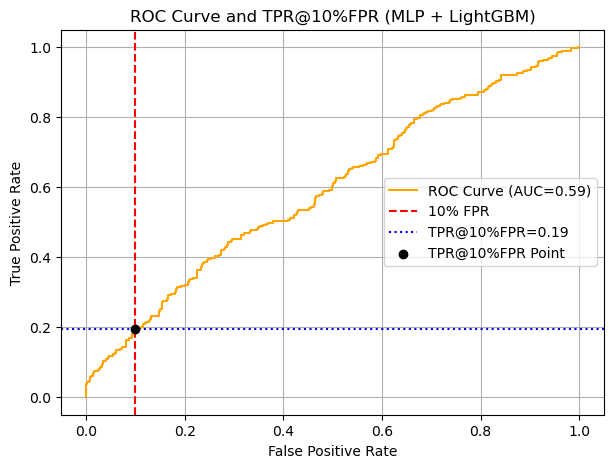

In [20]:
#best performance
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np


# Scale for MLP
scaler3 = StandardScaler()
X_train_scaled = scaler3.fit_transform(X_train)
X_val_scaled = scaler3.transform(X_val)

# Train LightGBM
lgb_model3 = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgb_model3.fit(X_train, y_train)

# Train MLP
mlp_model3 = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
mlp_model3.fit(X_train_scaled, y_train)

# Predict probabilities
lgb_probs3 = lgb_model3.predict_proba(X_val)[:, 1]
mlp_probs3 = mlp_model3.predict_proba(X_val_scaled)[:, 1]
ensemble_probs3 = 0.5 * lgb_probs3 + 0.5 * mlp_probs3

# Compute ROC & TPR@10%FPR
auc_score = roc_auc_score(y_val, ensemble_probs3)
fpr, tpr, _ = roc_curve(y_val, ensemble_probs3)
tpr_10_fpr = np.max(tpr[fpr <= 0.10]) if np.any(fpr <= 0.10) else 0.0

print(f"MLP + LightGBM Ensemble AUC: {auc_score:.3f}")
print(f"TPR@10%FPR: {tpr_10_fpr:.3f}")

# Plot ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC={auc_score:.2f})', color='orange')
plt.axvline(0.10, color='red', linestyle='--', label='10% FPR')
plt.axhline(tpr_10_fpr, color='blue', linestyle=':', label=f'TPR@10%FPR={tpr_10_fpr:.2f}')
plt.scatter([0.10], [tpr_10_fpr], color='black', zorder=5, label='TPR@10%FPR Point')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve and TPR@10%FPR (MLP + LightGBM)')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
import pandas as pd
import numpy as np
import os

# Directory to save o/p prediction results
OUTPUT_DIR = "mia_predictions_21_30"
os.makedirs(OUTPUT_DIR, exist_ok=True)

for idx in range(21, 31):
    print(f"Processing dataset {idx}...")
    features_df = all_distance_features[idx]  # shape (200, 17)
    
    # Scale for MLP (use scaler fitted on training set)
    features_scaled = scaler3.transform(features_df)
    
    # Predict probabilities with both models
    lgb_probs3 = lgb_model3.predict_proba(features_df)[:, 1]
    mlp_probs3 = mlp_model3.predict_proba(features_scaled)[:, 1]
    ensemble_probs3 = 0.5 * lgb_probs3 + 0.5 * mlp_probs3
    
    # Convert probabilities to hard labels (threshold = 0.5) to 1,0
    hard_labels = (ensemble_probs3 > 0.5).astype(int)
    
    # Prepare and save result DataFrame (both prob and hard label)
    out_df = features_df.copy()
    out_df["mia_score"] = ensemble_probs3  # membership probability
    out_df["mia_label"] = hard_labels     # 0 or 1 hard label

    out_path = os.path.join(OUTPUT_DIR, f"mia_predictions_tabddpm_{idx}.csv")
    out_df[["mia_score", "mia_label"]].to_csv(out_path, index=False)
    print(f"Saved: {out_path}")


Processing dataset 21...
Saved: mia_predictions_21_30/mia_predictions_tabddpm_21.csv
Processing dataset 22...
Saved: mia_predictions_21_30/mia_predictions_tabddpm_22.csv
Processing dataset 23...
Saved: mia_predictions_21_30/mia_predictions_tabddpm_23.csv
Processing dataset 24...
Saved: mia_predictions_21_30/mia_predictions_tabddpm_24.csv
Processing dataset 25...
Saved: mia_predictions_21_30/mia_predictions_tabddpm_25.csv
Processing dataset 26...
Saved: mia_predictions_21_30/mia_predictions_tabddpm_26.csv
Processing dataset 27...
Saved: mia_predictions_21_30/mia_predictions_tabddpm_27.csv
Processing dataset 28...
Saved: mia_predictions_21_30/mia_predictions_tabddpm_28.csv
Processing dataset 29...
Saved: mia_predictions_21_30/mia_predictions_tabddpm_29.csv
Processing dataset 30...
Saved: mia_predictions_21_30/mia_predictions_tabddpm_30.csv


In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd

results = []

for idx in range(21, 31):
    print(f"Evaluating dataset {idx}...")

    # Load your predictions
    pred_path = f"mia_predictions_21_30/mia_predictions_tabddpm_{idx}.csv"
    preds_df = pd.read_csv(pred_path)
    mia_probs = preds_df['mia_score'].values  

    # Load ground-truth labels
    label_path = f"/Users/tejaswiduptala/Desktop/AISP/tabddpm_black_box_adapted_pra/tabddpm_{idx}/challenge_label.csv"
    labels_df = pd.read_csv(label_path)
    y_true = labels_df['is_train'].values 

    # Compute ROC and AUC
    fpr, tpr, _ = roc_curve(y_true, mia_probs)
    auc = roc_auc_score(y_true, mia_probs)
    tpr_10_fpr = max(tpr[fpr <= 0.10]) if np.any(fpr <= 0.10) else 0.0

    print(f"Dataset {idx}: AUC = {auc:.3f}, TPR@10%FPR = {tpr_10_fpr:.3f}")
    results.append({'dataset': idx, 'AUC': auc, 'TPR@10%FPR': tpr_10_fpr})

# Summary table
results_df = pd.DataFrame(results)
print("\nSummary Table (Datasets 21–30):")
print(results_df)


Evaluating dataset 21...
Dataset 21: AUC = 0.614, TPR@10%FPR = 0.280
Evaluating dataset 22...
Dataset 22: AUC = 0.616, TPR@10%FPR = 0.160
Evaluating dataset 23...


Dataset 23: AUC = 0.546, TPR@10%FPR = 0.110
Evaluating dataset 24...
Dataset 24: AUC = 0.552, TPR@10%FPR = 0.150
Evaluating dataset 25...
Dataset 25: AUC = 0.518, TPR@10%FPR = 0.130
Evaluating dataset 26...
Dataset 26: AUC = 0.523, TPR@10%FPR = 0.140
Evaluating dataset 27...
Dataset 27: AUC = 0.619, TPR@10%FPR = 0.190
Evaluating dataset 28...
Dataset 28: AUC = 0.578, TPR@10%FPR = 0.240
Evaluating dataset 29...
Dataset 29: AUC = 0.589, TPR@10%FPR = 0.250
Evaluating dataset 30...
Dataset 30: AUC = 0.639, TPR@10%FPR = 0.160

Summary Table (Datasets 21–30):
   dataset     AUC  TPR@10%FPR
0       21  0.6138        0.28
1       22  0.6156        0.16
2       23  0.5462        0.11
3       24  0.5520        0.15
4       25  0.5183        0.13
5       26  0.5233        0.14
6       27  0.6187        0.19
7       28  0.5784        0.24
8       29  0.5885        0.25
9       30  0.6394        0.16
